In [169]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
import time
import sys
import os
from scipy.signal import savgol_filter
from scipy.interpolate import interp1d
from tqdm import tqdm
sys.path.append(os.path.join(os.getcwd(), "..", ".."))
from support.omniwheel_calculation import *
from datetime import datetime
from support.pd_support import *
from support.calculations_support import *
from support.ar_calculations import *
from numba import njit
import polars as pl
from scipy.signal import find_peaks
from scipy.signal import peak_widths
from scipy.signal import peak_prominences
from support.imu_calculations import *

In [170]:
_parent_folder = "encoder_validation"
_folder_name = "sk28_et_orange_t0"
_base_pth = os.path.dirname(os.getcwd())
_base_pth = os.path.join(_base_pth, "..","recording_programs", "test_data", _parent_folder)
_base_pth

'c:\\Users\\CMC\\Documents\\openposelibs\\pose\\armbo\\simulation\\..\\recording_programs\\test_data\\encoder_validation'

In [171]:
_sk_df = pd.read_csv(os.path.join(_base_pth, _folder_name, "imu01.csv"))
_sk_df["rust_time"] = _sk_df["rust_time"].apply(lambda x: datetime.fromtimestamp(x))
# set zero
_sk_df.rename(columns={"rust_time": "time", "e_fr":"e_t"}, inplace=True)

_sk_df = set_zero(_sk_df, column_name = ["e_t", "e_rr", "e_rl"])
# rename columns
_sk_df["e_t"] =  -_sk_df["e_t"]

_sk_df

,sys_time,time,e_t,e_fl,e_rr,e_rl,rtc,mils,sync,ax,ay,az,gx,gy,gz,mx,my,mz
0,2023-03-16 12:12:39.805231,2023-03-16 12:12:39.805260,0,0,0,0,2019-01-01 05.31.07.000000 AM,68097,0,-0.428869,0.264977,10.048802,-0.060976,-0.007622,0.022866,-4.500000,9.900001,-30.300001
1,2023-03-16 12:12:39.976381,2023-03-16 12:12:39.976475,0,0,0,0,2019-01-01 05.31.07.000000 AM,68110,0,-0.413915,0.260192,10.048203,-0.060976,-0.007622,0.030488,0.300000,9.900001,-38.100002
2,2023-03-16 12:12:39.976381,2023-03-16 12:12:39.976760,0,0,0,0,2019-01-01 05.31.07.000000 AM,68123,0,-0.436644,0.248827,10.058970,-0.068598,-0.015244,0.022866,2.700000,5.100000,-33.900002
3,2023-03-16 12:12:39.976877,2023-03-16 12:12:39.977056,0,0,0,0,2019-01-01 05.31.07.000000 AM,68135,0,-0.440831,0.240453,10.030858,-0.045732,-0.007622,0.015244,-11.700001,9.900001,-37.500000
4,2023-03-16 12:12:39.976877,2023-03-16 12:12:39.977323,0,0,0,0,2019-01-01 05.31.07.000000 AM,68148,0,-0.427074,0.252416,10.049998,-0.060976,-0.015244,0.022866,-2.100000,21.900002,-36.300003
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3007,2023-03-16 12:13:17.740283,2023-03-16 12:13:17.740670,21349,0,0,0,2019-01-01 05.31.45.000000 AM,106044,0,-0.439037,0.244042,10.036839,-0.060976,-0.015244,0.007622,-4.500000,12.300000,-35.100002
3008,2023-03-16 12:13:17.753143,2023-03-16 12:13:17.753328,21349,0,0,0,2019-01-01 05.31.45.000000 AM,106057,0,-0.441430,0.230883,10.054784,-0.060976,-0.015244,0.038110,-9.300000,14.700001,-35.700001
3009,2023-03-16 12:13:17.765544,2023-03-16 12:13:17.766005,21349,0,0,0,2019-01-01 05.31.45.000000 AM,106070,0,-0.437841,0.263183,10.050596,-0.068598,-0.007622,0.015244,-11.700001,7.500000,-36.900002
3010,2023-03-16 12:13:17.778439,2023-03-16 12:13:17.778684,21349,0,0,0,2019-01-01 05.31.45.000000 AM,106082,0,-0.433056,0.255407,10.069736,-0.060976,-0.015244,0.030488,-11.700001,-6.900000,-30.900002


In [184]:
# type in marker details
_xm = get_rb_marker_name(2)
_zm = get_rb_marker_name(1)
_om = get_rb_marker_name(3)

In [185]:
_mocap_df, st_time = read_rigid_body_csv(os.path.join(_base_pth, _folder_name.split("_")[0] ,_folder_name + ".csv"))
_mocap_df = add_datetime_col(_mocap_df, st_time, "seconds")
# _mocap_df.rb_marker_m3_x

In [186]:
# This cell is optimized to run faster using polars

# calculate rotation matrix from xvec, zvec, org
_m_df = _mocap_df.copy()
_m_df = pl.from_pandas(_m_df)

_rotmat_i = []
for i in tqdm(range(len(_m_df))):
    
    _x_vec = _m_df[[_xm["x"], _xm["y"], _xm["z"]]][i, :].to_numpy().T
    _z_vec = _m_df[[_zm["x"], _zm["y"], _zm["z"]]][i, :].to_numpy().T
    _org = _m_df[[_om["x"], _om["y"], _om["z"]]][i, :].to_numpy().T

    _rotmat_i.append(calculate_rotmat(_x_vec, _z_vec, _org))
# calculating del rotmat for mc
_del_r = []
for i in tqdm(range(len(_rotmat_i))):
    _del_r.append(_rotmat_i[i].T@_rotmat_i[0])

# calculating angle for mc
_theta_x = []
_theta_y = []
_theta_z = []

for i in tqdm(_del_r):
    _theta_x.append(np.arctan2(i[2,1], i[2,2]))
    _theta_y.append(np.arctan2(-i[2,0], np.sqrt(i[2,1]**2 + i[2,2]**2)))
    _theta_z.append(np.arctan2(i[1,0], i[0,0]))
    
_theta_x = np.array(_theta_x)
_theta_y = np.array(_theta_y)
_theta_z = np.array(_theta_z)

# converting them to degrees
_theta_x = np.rad2deg(_theta_x)
_theta_y = np.rad2deg(_theta_y)
_theta_z = np.rad2deg(_theta_z)


100%|██████████| 2749/2749 [00:00<00:00, 128897.53it/s]


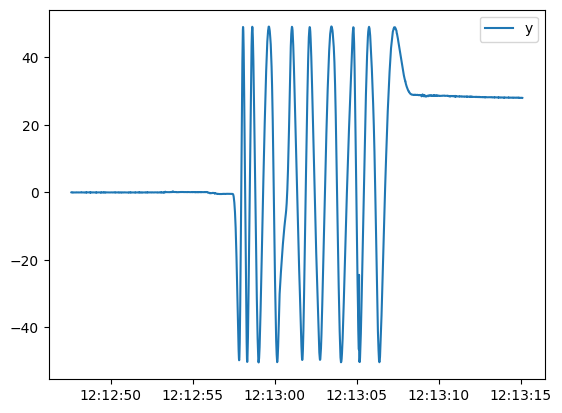

In [187]:
# plt.plot(_m_df["time"][1000:2000], _theta_x[1000:2000], label="x")

plt.plot(_m_df["time"], _theta_y, label="y")
# plt.plot(_m_df["time"][1000:2000], _theta_z[1000:2000], label="z")
# change angle to 0 to 360
plt.legend()
# max(_theta_z)

In [188]:
theta_df = pd.DataFrame({"time": _m_df["time"], "theta_y": _theta_y})
theta_df["diff"] = abs(theta_df["theta_y"].diff())
# replace nan with 0
theta_df["diff"].fillna(0, inplace=True)
# integrate angle
df, _ = get_orientation(theta_df, "diff")


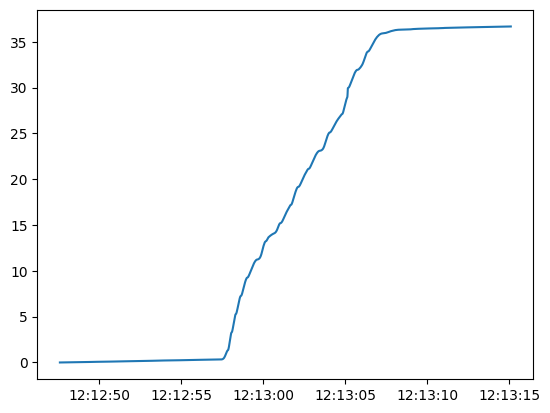

In [189]:
plt.plot(df["time"], df["theta"], label="y")

In [190]:
_ang_df = _sk_df[['time', 'e_t']].copy()

In [191]:
_ang_df["ang_y"] = _ang_df["e_t"].apply(lambda x: x*0.147)
_ang_df["diff"] = abs(_ang_df["ang_y"].diff())
# replace nan with 0
_ang_df["diff"].fillna(0, inplace=True)
# integrate angle
_new_ang_df, _ = get_orientation(_ang_df, "diff")
_new_ang_df

,time,e_t,ang_y,diff,theta
0,2023-03-16 12:12:39.805260,0,0.000,0.0,0.00000
1,2023-03-16 12:12:39.976475,0,0.000,0.0,0.00000
2,2023-03-16 12:12:39.976760,0,0.000,0.0,0.00000
3,2023-03-16 12:12:39.977056,0,0.000,0.0,0.00000
4,2023-03-16 12:12:39.977323,0,0.000,0.0,0.00000
...,...,...,...,...,...
3007,2023-03-16 12:13:17.740670,21349,3138.303,0.0,62.80722
3008,2023-03-16 12:13:17.753328,21349,3138.303,0.0,62.80722
3009,2023-03-16 12:13:17.766005,21349,3138.303,0.0,62.80722
3010,2023-03-16 12:13:17.778684,21349,3138.303,0.0,62.80722


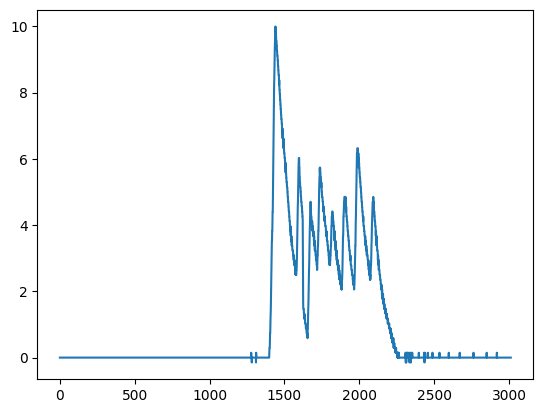

In [192]:
plt.plot(_ang_df["ang_y"].diff())

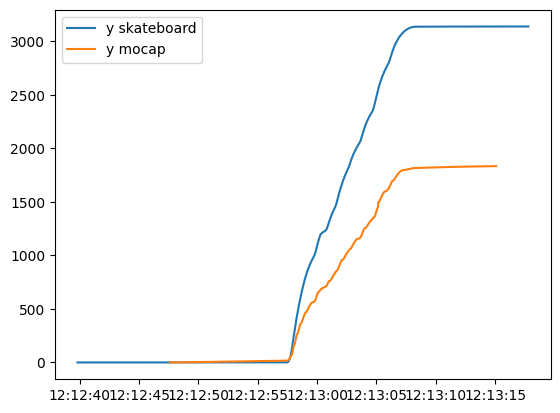

In [193]:
plt.plot(_ang_df["time"], _new_ang_df["ang_y"], label="y skateboard")
# plt.plot(_ang_df["time"], _ang_df["ang_y"], label="y skateboard wo fileter")
plt.plot(df["time"], df["theta"]*50, label="y mocap")
plt.legend()

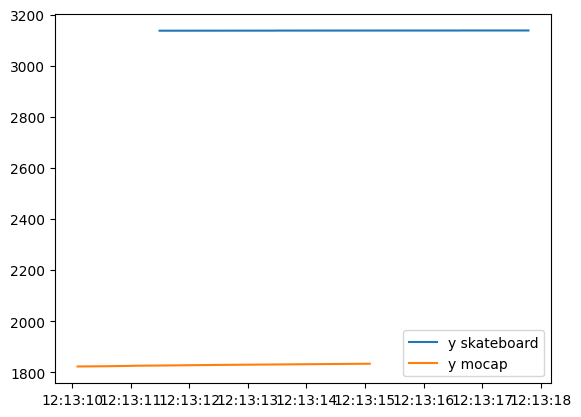

In [194]:
plt.plot(_ang_df["time"][-500:], _new_ang_df["ang_y"][-500:], label="y skateboard")
# plt.plot(_ang_df["time"][-500:], _ang_df["ang_y"][-500:], label="y skateboard wo filter")
plt.plot(df["time"][-500:], df["theta"][-500:]*50, label="y mocap")
plt.legend()